In [94]:
import pandas as pd
from sqlalchemy import create_engine
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [12]:
#get twitter comments 
df = pd.read_sql_query("SELECT * FROM twitter_comments",con = create_engine('mysql+pymysql://*********@*********/examination_sma'))

In [36]:
#method to clean the twitter comments, this is a bit different than the on in the topic_modeling, because VADER can work with emojis, so i could leave them in
def text_cleaner(text):
    text = re.sub('http\S+','',text)
    text = re.sub('@[A-Za-z0-9]+','',text) #removing mentions
    text = re.sub('@[0-9a-z]+','',text) #removing mention starting with numbers
    text = re.sub('#','',text) #removing hashtags
    text = re.sub(':[a-z]*','',text)
    if text == '':
        text = None
    if text == ' ':
        text = None
    return text

In [37]:
#clean the comments with text cleaner method
df['cleaned_text'] = df['comment'].apply(lambda x: text_cleaner(x))

In [40]:
#getting rid of text where there is no text
df = df[df['cleaned_text'].notna()].reset_index(drop=True)

In [47]:
#applying the analyser on all comments themselves
analyzer = SentimentIntensityAnalyzer()
df['sentiment_value'] = df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x))

In [48]:
#format the big dataframe into three smaller where i filtered after the username and dropping the index afterwards
df_greta = df[df['username']=='GretaThunberg'].reset_index(drop=True)
df_david = df[df['username']=='DavidDobrik'].reset_index(drop=True)
df_joe = df[df['username']=='JoeBiden'].reset_index(drop=True)

In [61]:
#Method to calculate the mean scores of all scores in the comments
def get_mean_scores(df):
    positive = 0
    negative = 0 
    neutral = 0
    compound = 0
    for i in range(len(df)):
        positive = positive + df.at[i,'sentiment_value']['pos']
        negative = negative + df.at[i,'sentiment_value']['neg']
        neutral = neutral + df.at[i,'sentiment_value']['neu']
        compound = compound + df.at[i,'sentiment_value']['compound']
    positive_mean = positive/len(df)
    negative_mean = negative/len(df)
    neutral_mean = neutral/len(df)
    compound_mean = compound/len(df)
    return positive_mean,neutral_mean,negative_mean,compound_mean

In [63]:
#calculate mean scores with get_mean_scores() method
pos_mean_greta,neu_mean_greta,neg_mean_greta,com_mean_greta=get_mean_scores(df_greta)
pos_mean_joe,neu_mean_joe,neg_mean_joe,com_mean_joe=get_mean_scores(df_joe)
pos_mean_david,neu_mean_david,neg_mean_david,com_mean_david=get_mean_scores(df_david)

In [65]:
#creating dataframe for further processing
pos_list = [pos_mean_greta,pos_mean_joe,pos_mean_david]
neu_list = [neu_mean_greta,neu_mean_joe,neu_mean_david]
neg_list = [neg_mean_greta,neg_mean_joe,neg_mean_david]
com_list = [com_mean_greta,com_mean_joe,com_mean_david]
name_list = ['GretaThunberg','JoeBiden','DavidDobrik']
data = {'username':name_list,'positive':pos_list,'neutral':neu_list,'negativ':neg_list,'compound':com_list}
df_sentiment_mean = pd.DataFrame(data=data)

In [67]:
#result of mean calculation
df_sentiment

,username,positive,neutral,negativ,compound
0,GretaThunberg,0.120389,0.768985,0.095903,0.016972
1,JoeBiden,0.110457,0.738977,0.120774,-0.065406
2,DavidDobrik,0.141551,0.773151,0.075482,0.125735


In [88]:
#taking whole texts as one to get a plot of compound
text_greta= ''.join(list(df_greta['cleaned_text']))
text_david = ''.join(list(df_david['cleaned_text']))
text_joe = ''.join(list(df_joe['cleaned_text']))

In [89]:
full_greta = analyzer.polarity_scores(text_greta)
full_david = analyzer.polarity_scores(text_david)
full_joe = analyzer.polarity_scores(text_joe)

In [90]:
#creating dataframe for further processing
pos_list_full = [full_greta['pos'],full_joe['pos'],full_david['pos']]
neu_list_full = [full_greta['neu'],full_joe['neu'],full_david['neu']]
neg_list_full = [full_greta['neg'],full_joe['neg'],full_david['neg']]
com_list_full = [full_greta['compound'],full_joe['compound'],full_david['compound']]
name_list_full = ['GretaThunberg','JoeBiden','DavidDobrik']
data = {'username':name_list_full,'positive':pos_list_full,'neutral':neu_list_full,'negativ':neg_list_full,'compound':com_list_full}
df_sentiment_full = pd.DataFrame(data=data)

In [91]:
#result of the full text analyse
df_sentiment_full

,username,positive,neutral,negativ,compound
0,GretaThunberg,0.144,0.726,0.130,0.9994
1,JoeBiden,0.144,0.692,0.164,-1.0000
2,DavidDobrik,0.187,0.694,0.118,0.9999


Text(0.5, 0.98, 'Comparison of positive to negative sentiments on twitter comments')

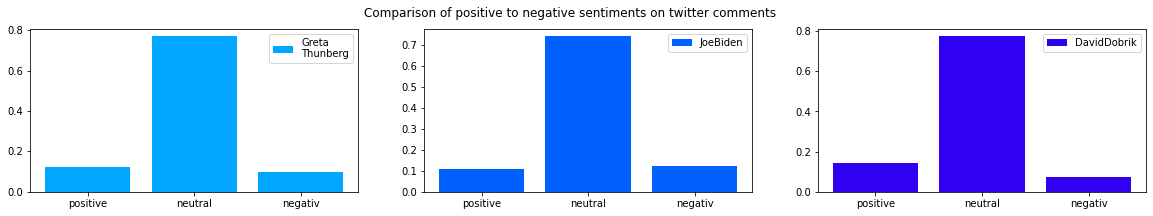

In [108]:
#decision to go on with mean
#plotting
sen_values_0 = [df_sentiment.at[0,'positive'],df_sentiment.at[0,'neutral'],df_sentiment.at[0,'negativ']]
labels_0 = ['positive','neutral','negativ']
sen_values_1 = [df_sentiment.at[1,'positive'],df_sentiment.at[1,'neutral'],df_sentiment.at[1,'negativ']]
labels_1 = ['positive','neutral','negativ']
sen_values_2 = [df_sentiment.at[2,'positive'],df_sentiment.at[2,'neutral'],df_sentiment.at[2,'negativ']]
labels_2 = ['positive','neutral','negativ']

fig, ax = plt.subplots(1,3,figsize=(20,3),sharey=False)
ax[0].bar(labels_0,sen_values_0,label="""Greta
Thunberg""",color="#00A6FF")
ax[0].legend()
ax[1].bar(labels_1,sen_values_1,label="""JoeBiden""",color='#0061FF')
ax[1].legend()
ax[2].bar(labels_2,sen_values_2,label="""DavidDobrik""",color='#3000f0')
ax[2].legend()
fig.suptitle('Comparison of positive to negative sentiments on twitter comments')

Text(0.5, 0.98, 'Comparison of compound sentiment value on twitter comments')

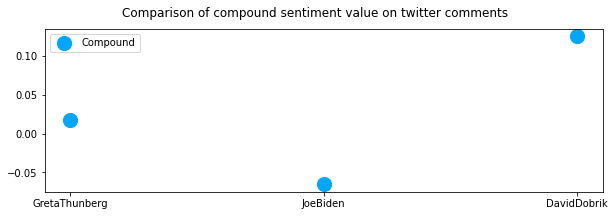

In [109]:
sen_values = list(df_sentiment['compound'])
labels = list(df_sentiment['username'])

fig, ax = plt.subplots(figsize=(10,3),sharey=False)
ax.scatter(labels,sen_values,label="""Compound""",color="#00A6FF",s=200)
ax.legend()
fig.suptitle('Comparison of compound sentiment value on twitter comments')